## plt 101

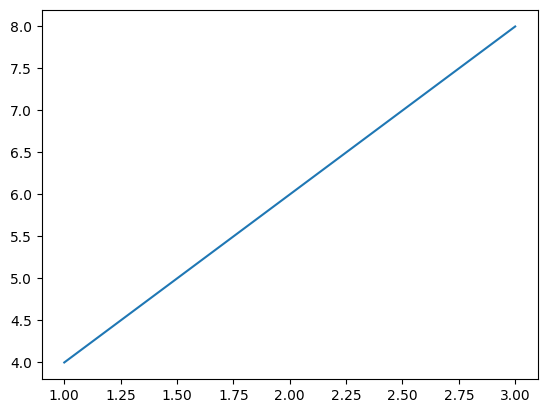

In [1]:
import polars as pl
import matplotlib.pyplot as plt


df_demo = pl.DataFrame({"x": [1, 2, 3], "y": [4, 6, 8]})
fig_demo, ax_demo = plt.subplots()
ax_demo.plot(df_demo["x"], df_demo["y"])

## Code

In [ ]:
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
from highlight_text import ax_text
from matplotlib import colormaps

# https://github.com/mattharrison/datasets/raw/refs/heads/master/data/alta-noaa-1980-2019.csv
idx_colname = "DAY_OF_SEASON"
data_path = "alta-noaa-1980-2019.csv"
columns = ["DATE", "TOBS"]


def tweak_df(
    data_path: str, columns: list[str], idx_colname: str = "DAY_OF_SEASON"
):
    return (
        pl.scan_csv(data_path)
        .select(columns)
        .with_columns(
            pl.col("DATE").str.to_datetime(),
            pl.col("TOBS").interpolate(),
        )
        .sort("DATE")
        .with_columns(
            # Caveat: Cannot be placed in the previous `with_columns()`
            # due to different statuses of `TOBS`.
            pl.col("TOBS")
            .rolling_mean(window_size=28, center=True)
            .alias("TMEAN"),
            get_season_expr(col="DATE", alias="SEASON"),
        )
        .with_columns(
            add_day_of_season_expr(
                col="DATE", group_col="SEASON", alias=idx_colname
            )  #
        )
        .collect()
    )


def get_season_expr(col: str = "DATE", alias: str = "SEASON") -> pl.expr:
    return (
        (
            pl.when(
                (pl.col(col).dt.month().is_between(5, 10, closed="both"))
            )
            .then(pl.lit("Summer "))
            .otherwise(pl.lit("Ski "))
        )
        .add(
            pl.when(pl.col(col).dt.month() < 11)
            .then(pl.col(col).dt.year().cast(pl.String))
            .otherwise(pl.col(col).dt.year().add(1).cast(pl.String))
        )
        .alias(alias)
    )


def add_day_of_season_expr(
    col: str = "DATE",
    group_col: str = "SEASON",
    alias: str = "DAY_OF_SEASON",
) -> pl.expr:
    return (
        (pl.col(col) - pl.col(col).min())
        .dt.total_days()
        .over(group_col)
        .alias(alias)
    )


def plot_temps(
    _df: pl.DataFrame, idx_colname: str = "DAY_OF_SEASON"
) -> pl.DataFrame:
    plt.rcParams["font.family"] = "Roboto"
    figsize = (160, 165)  # pts

    def points_to_inches(points):
        return points / 72

    figsize_inches = [points_to_inches(dim) for dim in figsize]

    heading_fontsize = 9.5
    heading_fontweight = "bold"
    subheading_fontsize = 8
    subheading_fontweight = "normal"
    source_fontsize = 6.5
    source_fontweight = "light"
    axis_fontsize = 7
    axis_fontweight = "normal"

    grey = "#aaaaaa"
    red = "#e3120b"
    blue = "#0000ff"
    cmap = colormaps.get_cmap("Grays")

    layout = [["title"], ["plot"], ["notes"]]
    fig, axs = plt.subplot_mosaic(
        layout,
        gridspec_kw={"height_ratios": [6, 12, 1]},
        figsize=figsize_inches,
        dpi=300,
        constrained_layout=True,
    )

    # ----- Title -----
    ax_title = axs["title"]
    ax_title.axis("off")
    sub_props = {
        "fontsize": subheading_fontsize,
        "fontweight": subheading_fontweight,
    }
    ax_text(
        s="<Alta Ski Resort>\n<Temperature trends by >\n<decade>< and ><2019>",
        x=0,
        y=0,
        fontsize=heading_fontsize,
        ax=ax_title,
        va="bottom",
        ha="left",
        zorder=5,
        highlight_textprops=[
            {
                "fontsize": heading_fontsize,
                "fontweight": heading_fontweight,
            },
            sub_props,
            {"color": blue, **sub_props},
            sub_props,
            {"color": red, **sub_props},
        ],
    )

    # ----- Plot -----
    ax = axs["plot"]
    season_temps = _df.filter(pl.col("SEASON").str.contains("Ski")).pivot(
        "SEASON",
        index=idx_colname,
        values="TMEAN",
        aggregate_function="first",
    )
    season_temps_index = season_temps[idx_colname]

    columns = season_temps.columns
    columns.remove(idx_colname)
    columns.remove("Ski 2019")
    for i, column in enumerate(columns):
        color = cmap(i / len(columns))
        ax.plot(
            season_temps_index,
            season_temps[column],
            color=color,
            linewidth=1,
            alpha=0.2,
            zorder=1,
        )

    # # ---- Decade Averages ----
    decades = [1980, 1990, 2000, 2010]
    blues = ["#0055EE", "#0033CC", "#0011AA", "#3377FF"]
    for decade, color in zip(decades, blues):
        match = str(decade)[:-1]  # 1980 -> "198", 2010 -> "201"
        decade_temps = season_temps.select(
            cs.contains(match)
        ).mean_horizontal()
        ax.plot(season_temps_index, decade_temps, color=color, linewidth=1)

        # add label to right of line
        last_y_label = decade_temps.last()

        if decade == 2000:
            last_y_label -= 3
        elif decade == 2010:
            last_y_label -= 0.3

        ax.text(
            185,
            last_y_label,
            f"{decade}",
            va="center",
            ha="left",
            fontsize=axis_fontsize,
            fontweight=axis_fontweight,
            color=color,
        )
        # # add dot to start and end of each line
        ax.plot(
            season_temps_index.first(),
            decade_temps.first(),
            marker="o",
            color=color,
            markersize=1,
            zorder=2,
        )
        ax.plot(
            season_temps_index.last(),
            decade_temps.last(),
            marker="o",
            color=color,
            markersize=1,
            zorder=2,
        )

    # # ------ Ski 2019 ------
    # # plot `Ski 2019` in red
    ski_2019 = season_temps.select(
        idx_colname, cs.by_name("Ski 2019")
    ).drop_nulls()
    ski_2019_index = ski_2019[idx_colname]
    ski_2019 = ski_2019.drop([idx_colname]).to_series()
    ax.plot(ski_2019_index, ski_2019, color="red", linewidth=1)

    # add dot to start and end of each line
    ax.plot(
        ski_2019_index.first(),
        ski_2019.first(),
        marker="o",
        color="red",
        markersize=2,
        zorder=2,
    )
    ax.plot(
        ski_2019_index.last(),
        ski_2019.last(),
        marker="o",
        color="red",
        markersize=2,
        zorder=2,
    )

    # # ------ Ticks & Lines ------
    # # remove spines
    for side in ["top", "left", "right"]:
        ax.spines[side].set_visible(False)

    # # add horizontal line at 32F
    ax.axhline(32, color="black", linestyle="--", linewidth=1, zorder=1)

    # # set y ticks
    ax.set_yticks(ticks=[10, 32, 40])

    # # set y limit
    ax.set_ylim([10, 55])

    # # set x label
    ax.set_xlabel(
        "Day of season", fontsize=axis_fontsize, fontweight=axis_fontweight
    )

    # # ------ Source ------
    ax_notes = axs["notes"]
    # add source
    ax_notes.axis("off")
    ax_notes.text(
        0,
        0,
        "Source: NOAA",
        fontsize=source_fontsize,
        fontweight=source_fontweight,
        color=grey,
    )
    return _df


df = tweak_df(data_path, columns, idx_colname)
df.pipe(plot_temps, idx_colname)